# Finding Regions

For each zillow region:
1. Find k closest neighbors
2. Find k closest taxi neighbors
3. Using the edge data, compare connected subregions

In [1]:
from __future__ import print_function 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import datetime as dt

mpl.rcParams['savefig.dpi'] = 100 
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams.update({'font.size': 40})

%config InlineBackend.figure_format = 'retina' 
%matplotlib inline

import matplotlib.dates as mdates

In [25]:
import json
from shapely.geometry import mapping, shape
from shapely.ops import cascaded_union
taxi_zones = json.load(open('taxi_zones.geojson'))
z_hoods = json.load(open('ZillowNeighborhoods-NY.geojson'))

class Neighborhood(object):
    def __init__(self, feature):
        self.properties = feature['properties']
        self.geometry = feature['geometry']
        self.shape = shape(feature['geometry'])

z_hoods_shapes = [Neighborhood(f)
                  for f in z_hoods['features']
                  if f['properties']['City'] == 'New York']
taxi_zones_shapes = [Neighborhood(f) for f in taxi_zones['features']]

In [3]:
print('Zillow neighborhoods:', len(z_hoods_shapes))
print('Taxi zones:', len(taxi_zones_shapes))

Zillow neighborhoods: 278
Taxi zones: 263


Visualize what "close" areas look like.

In [4]:
############################
# How many nearby regions to consider when looking for groups?
K = 5
############################

from shapely.geometry.point import Point
test_pt = z_hoods_shapes[8].shape.centroid

# 10 closest z's and t's
near_zs = sorted(z_hoods_shapes[:], key=lambda z:test_pt.distance(z.shape.centroid))[:K]
near_ts = sorted(taxi_zones_shapes[:], key=lambda t:test_pt.distance(t.shape.centroid))[:K]

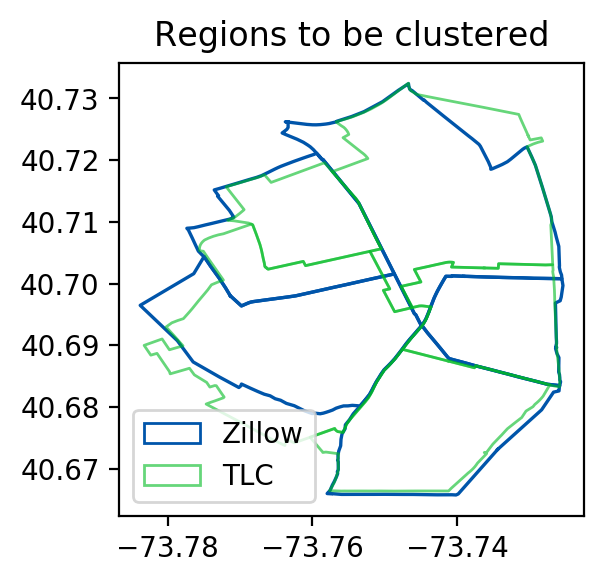

In [5]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

z_col = '#0055aaff'
t_col = '#00bb2299'

z_patch = mpatches.Patch(facecolor='white', edgecolor=z_col, label='Zillow')
t_patch = mpatches.Patch(facecolor='white', edgecolor=t_col, label='TLC')

def plot(shape, **kwargs):
    if shape.type == 'MultiPolygon':
        for g in shape.geoms:
            plot(g, **kwargs)
    else:
        x, y = shape.exterior.xy
        plt.plot(x ,y, **kwargs)

plt.figure(figsize=(3,3))
plt.title('Regions to be clustered')
[plot(z.shape, color=z_col, linewidth=1.2) for z in near_zs]
[plot(t.shape, color=t_col, linewidth=1) for t in near_ts]
plt.legend(handles=[z_patch, t_patch], loc='best')
plt.show()

In [6]:
# Load adjacency data.
import json
t_edges = json.load(open('taxi_zones_LocationID_edges.json', 'r'))
z_edges = json.load(open('ZillowNeighborhoods_RegionID_edges.json', 'r'))

In [7]:
len(t_edges)

895

In [8]:
# Fit them into graphs.
import networkx as nx
T = nx.Graph()
T.add_edges_from(t_edges)
T = nx.freeze(T)
Z = nx.Graph()
Z.add_edges_from(z_edges)
Z = nx.freeze(Z)

In [9]:
z_ids = [int(z.properties['RegionID']) for z in near_zs]
t_ids = [int(t.properties['LocationID']) for t in near_ts]
Tnear = T.subgraph(t_ids)
Znear = Z.subgraph(z_ids)

In [10]:
import itertools
def generate_connected_subgraphs(G):
    all_nodes = list(G)
    for sz in xrange(1, len(G)):
        for nodes in itertools.combinations(all_nodes, sz):
            subG = G.subgraph(nodes)
            if nx.is_connected(subG):
                yield subG
    yield G

In [11]:
print(len([list(x) for x in list(generate_connected_subgraphs(Tnear))]))
print(len([list(x) for x in list(generate_connected_subgraphs(Znear))]))

26
28


# Fetch Result From EMR

In [12]:
regionid_to_z = {int(z.properties['RegionID']): z for z in z_hoods_shapes}
locid_to_t = {int(t.properties['LocationID']): t for t in taxi_zones_shapes}

In [17]:
import pandas as pd
pairs = []
join_k8 = pd.read_csv('join_k8.csv', header=None, index_col=None)
join_k8.columns = ['tid', 'zid', 'jaccard']
print(len(join_k8))

282528


In [18]:
join_k8[:5]

,tid,zid,jaccard
0,240|259,343206|343225|403208,0.959000
1,16|64|175,26254|37309|273478,0.952521
2,82|83|157|160|198|226|260,5837|196338|199091|275173|275620|403223,0.951943
3,19|38|101|191,50348|55801|275115|403225|403226,0.948227
4,16|19|64|101|175,26254|37309|55801|273478|403225|403226,0.945374


In [19]:
pairs = []
for cluster in join_k8.itertuples():
    tids = [int(t) for t in cluster.tid.split('|')]
    zids = [int(t) for t in cluster.zid.split('|')]
    pairs.append(((tids, zids), cluster.jaccard))
len(pairs)

282528

In [95]:
def rescore(score, len_t, len_z):
    return score * 0.93**(max(len_t, len_z) * 1.0)

def rescorer(cluster):
    ((tids, zids), jaccard) = cluster
    return rescore(jaccard, len(tids), len(zids))

spairs = sorted(pairs, key=rescorer, reverse=True)
spairs[:10]

[(([159], [403210]), 0.92363904728259683),
 (([43], [273205]), 0.90166497041357363),
 (([198], [275173]), 0.89688707661203815),
 (([177], [270902]), 0.89210790445716337),
 (([190], [403161]), 0.88238604692956657),
 (([35], [193526]), 0.88230400811868748),
 (([119], [343208]), 0.87817801315045052),
 (([31], [403214]), 0.8759484605777792),
 (([112], [270848]), 0.87017071284751846),
 (([139], [274285]), 0.86905476640376678)]

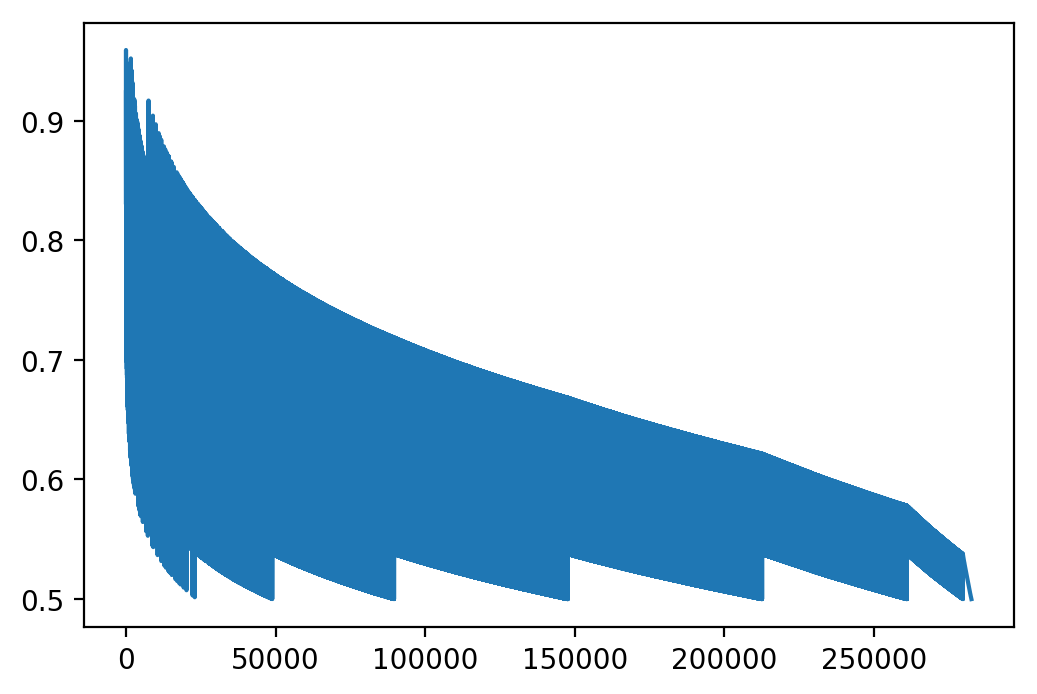

In [96]:
plt.figure()
plt.plot([score for cluster, score in spairs])
plt.show()

In [97]:
# Visualize.
t_shapes = []
z_shapes = []
t_seen = {}
z_seen = {}
cleaned_pairs = []
for (t_ids, z_ids), _ in spairs[:]:
    if any((t in t_seen) for t in t_ids) or any((z in z_seen) for z in z_ids):
        continue
    for t in t_ids:
        t_seen[t] = True
    for z in z_ids:
        z_seen[z] = True
    cleaned_pairs.append((t_ids, z_ids))

    t_shape = cascaded_union([locid_to_t[locid].shape for locid in t_ids])
    z_shape = cascaded_union([regionid_to_z[regid].shape for regid in z_ids])
    t_shapes.append(t_shape)
    z_shapes.append(z_shape)

In [98]:
print(len(cleaned_pairs))
len(z_shapes)

133


133

In [101]:
import pickle
# De-duplicated
pickle.dump(cleaned_pairs, open('TLocID_ZRegID_pairs.pickle', 'wb'))

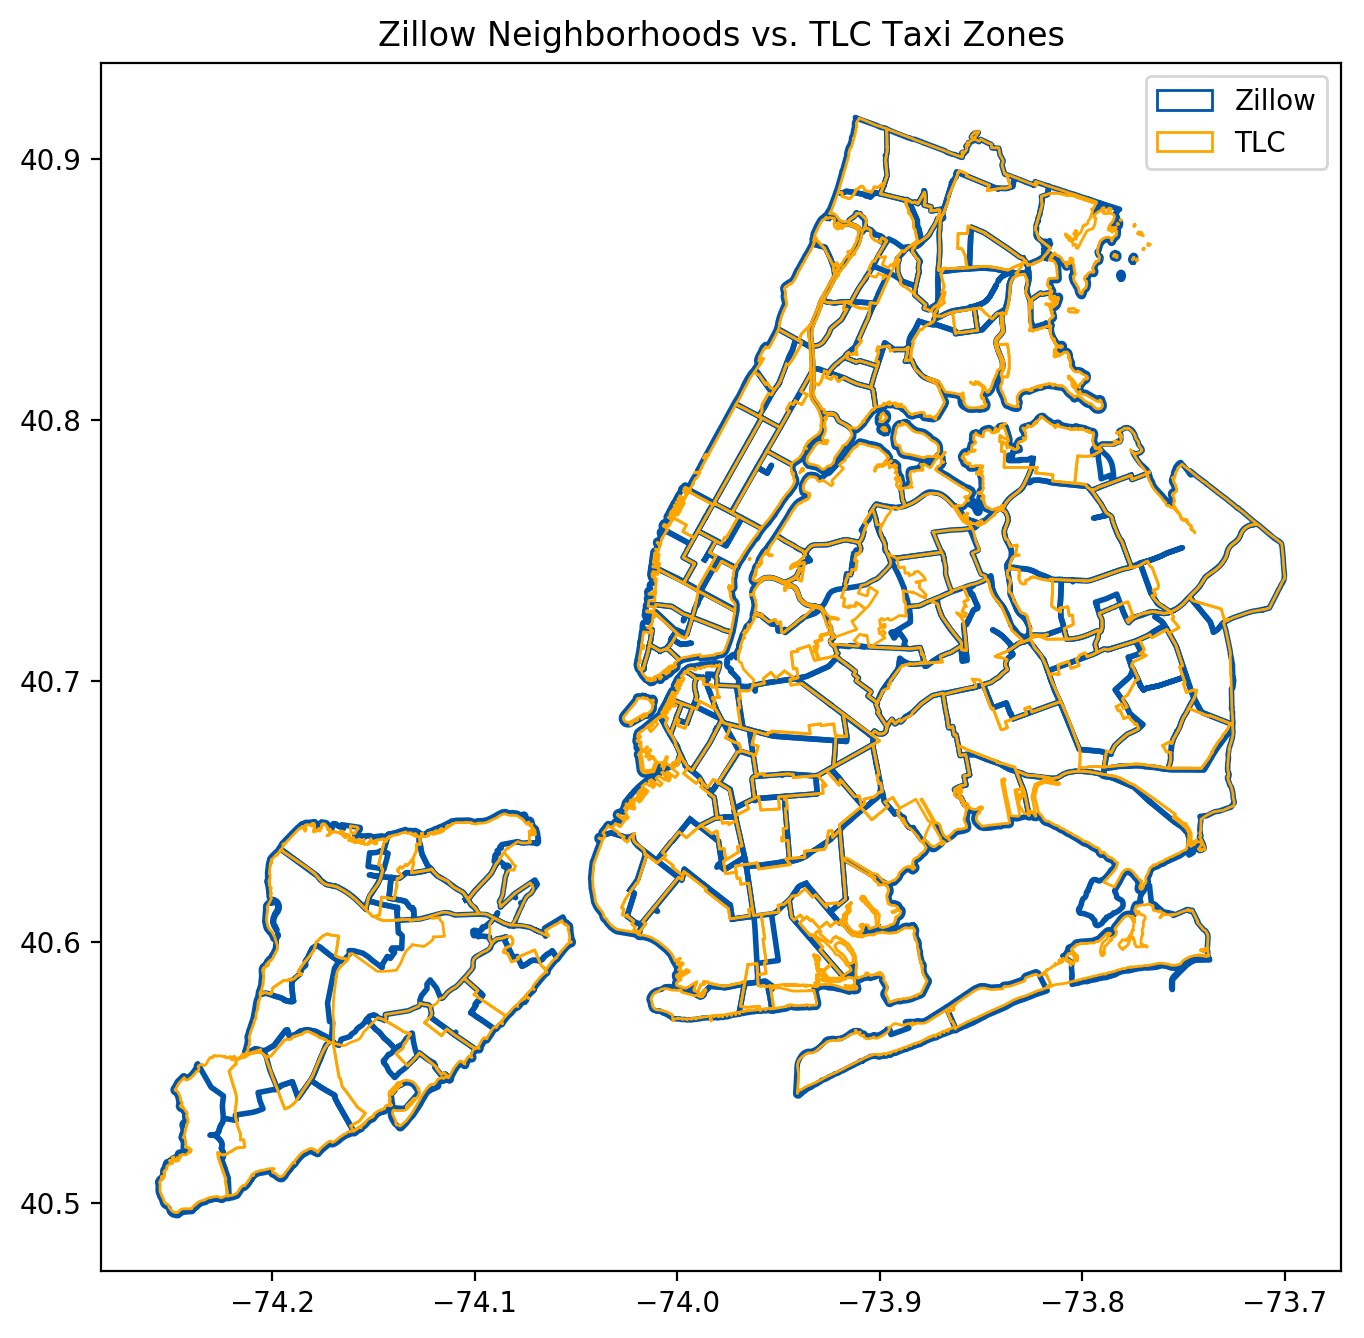

In [100]:
z_col = '#0055aaff'
t_col = 'orange'

z_patch = mpatches.Patch(facecolor='white', edgecolor=z_col, label='Zillow')
t_patch = mpatches.Patch(facecolor='white', edgecolor=t_col, label='TLC')

plt.figure(figsize=(8,8))
plt.title('Zillow Neighborhoods vs. TLC Taxi Zones')
[plot(z, color=z_col, linewidth=2) for z in z_shapes]
[plot(t, color=t_col, linewidth=1) for t in t_shapes]
plt.legend(handles=[z_patch, t_patch], loc='best')
plt.show()

In [102]:
cleaned_pairs[3]

([177], [270902])

In [103]:
locid_to_t[129].properties

{u'LocationID': 129,
 u'OBJECTID': 129,
 u'Shape_Area': 0.00047398833179,
 u'Shape_Leng': 0.0932727273403,
 u'borough': u'Queens',
 u'zone': u'Jackson Heights'}

In [104]:
mapping = []
composite_id = 1
for (t_ids, z_ids) in cleaned_pairs:
    name = '-'.join([str(locid_to_t[id].properties['zone']) for id in t_ids])
    if len(z_ids) < len(t_ids):
        name = '-'.join([str(regionid_to_z[id].properties['Name']) for id in z_ids])
    mapping.append({
            'id': composite_id,
            'name': name,
            'taxi_ids': t_ids,
            'zillow_ids': z_ids
            })
    composite_id += 1
print(len(mapping))
mapping[:4]

133


[{'id': 1, 'name': 'Melrose South', 'taxi_ids': [159], 'zillow_ids': [403210]},
 {'id': 2, 'name': 'Central Park', 'taxi_ids': [43], 'zillow_ids': [273205]},
 {'id': 3, 'name': 'Ridgewood', 'taxi_ids': [198], 'zillow_ids': [275173]},
 {'id': 4, 'name': 'Ocean Hill', 'taxi_ids': [177], 'zillow_ids': [270902]}]

In [105]:
import json
json.dump(mapping, open('taxi_zillow_mapping.json', 'wb'))

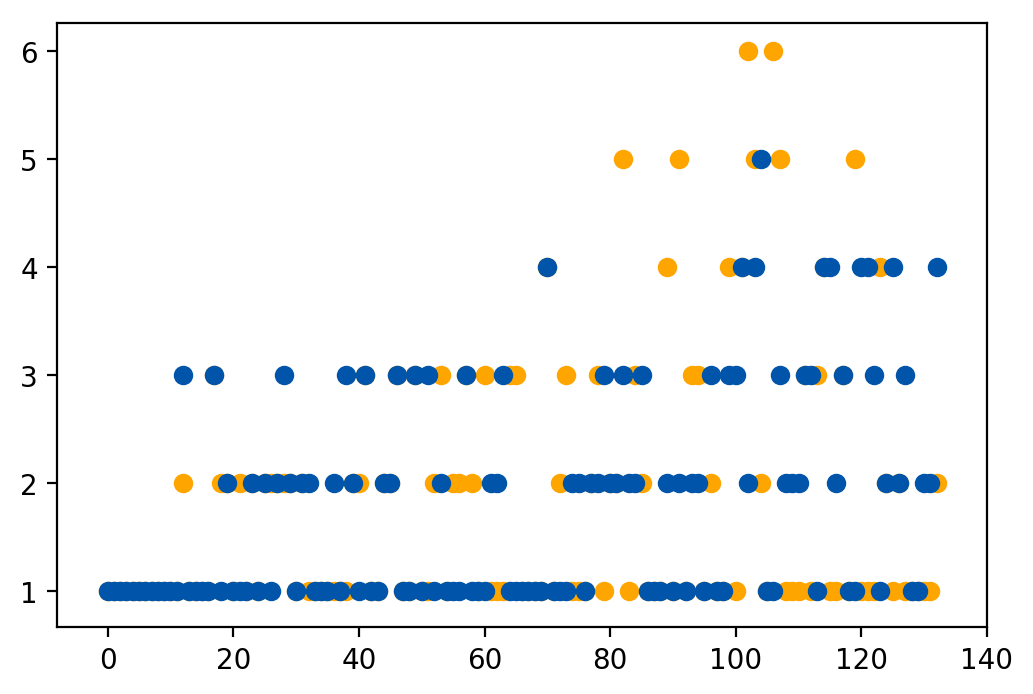

In [106]:
plt.figure()
plt.scatter(range(len(mapping)), [len(x['taxi_ids']) for x in mapping], color=t_col)
plt.scatter(range(len(mapping)), [len(x['zillow_ids']) for x in mapping], color=z_col)